In [1]:
import gym
import torch
import time
from stable_baselines3 import PPO
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback, EventCallback, CheckpointCallback, EvalCallback, CallbackList
from stable_baselines3.common.env_util import make_vec_env
from model_arm_imitation import *
from model_wholebody import *

2024-04-11 16:35:49.289777: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 16:35:49.289810: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 16:35:49.292034: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-11 16:35:49.298627: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 16:35:50.448604: W tensorflow/compiler/tf2

In [4]:
action_bounds = np.array([4.5, 4.5, 12.2, 12.2, 0.9,4.5, 4.5, 12.2, 12.2, 0.9, 3.14159, 2.40855, 2.659881, 3.14159, 2.23402, 3.14159])
action_bounds.shape
print(-action_bounds)

[ -4.5       -4.5      -12.2      -12.2       -0.9       -4.5
  -4.5      -12.2      -12.2       -0.9       -3.14159   -2.40855
  -2.659881  -3.14159   -2.23402   -3.14159 ]


In [2]:
env = CassieArmEnv(datafile="dataset/data1.json", render_mode="human")

In [9]:
def mass_center(model, data):
    mass = np.expand_dims(model.body_mass, axis=1)
    xpos = data.xipos
    return (np.sum(mass * xpos, axis=0) / np.sum(mass)).copy()

mass_center(env.model, env.data)

array([-1.53585636e-02, -3.53646569e-04,  9.93074925e-01])

In [14]:
for i in range(100000):
    # env.reset()
    pelvis_pose, pelvis_vel= env.ref_trajectory.state(i)
    env.set_cassie_qpos(pelvis_pose)
    env.do_simulation(np.zeros(22), 1)
    env.mj_viewer.render()
    time.sleep(0.01)
    print(i)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172


KeyboardInterrupt: 

In [3]:
env.data.qpos
print(env.data.qpos.shape)

(41,)


In [5]:
obs,_ = env.reset_model()




In [6]:
print(obs["observation"].shape)

(115,)


In [7]:
pelvis_pose, pelvis_ori, pelvis_vel = env.mass_center(env.model, env.data)
ref_qpos_cassie, ref_qvel_cassie = env.ref_trajectory.state(1)

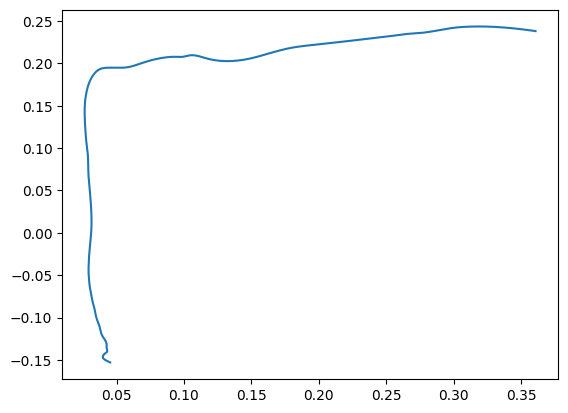

In [28]:
# plot the reference trajectory base position
import matplotlib.pyplot as plt
x, y, z = [], [], []
i = 0
while i < 600:
    try:
        pelvis_pose, pelvis_vel= env.ref_trajectory.state(i)
        x.append(pelvis_pose[0])
        y.append(pelvis_pose[1])
        z.append(pelvis_pose[2])
        # env.step(env.action_space.sample())
        # print(len(x))
        i += 1
    except:
        break

plt.plot(x,y, label='reference trajectory')
plt.show()

In [30]:
env.data_obs[0:3]

array([ 0.52541667, -1.19899327,  0.59467176])

In [29]:
env.data.sensor("end-effector-pos").data

array([ 0.72058211, -0.09473813,  1.55420063])

In [9]:
print(pelvis_pose)
print(pelvis_ori)
print(pelvis_vel)
print(ref_qpos_cassie)
print(ref_qvel_cassie)

[ 3.15586944e-02 -7.45056302e-06  9.30040987e-01]
[ 1.00000000e+00  6.92855015e-06 -2.57882801e-06  7.41606118e-06]
[5.80650979e-02 3.42954478e-05 5.12080333e-02]
[ 4.52557869e-02 -1.53017367e-01  9.70983762e-01  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  4.51603944e-02
  7.66990394e-04  4.89771303e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.30182238e+00 -3.88888098e-02
  1.60618574e+00  0.00000000e+00 -1.68356405e+00  0.00000000e+00
 -1.68356405e+00 -4.51910740e-02 -7.97670010e-04  4.89819240e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.30191826e+00 -3.88169045e-02  1.60616177e+00  0.00000000e+00
 -1.68360719e+00  0.00000000e+00 -1.68360719e+00]
[-1.68563721e-02 -5.36192164e-03 -1.12673867e-02  2.29415808e-03
 -1.60822129e-02  1.76290320e-03  4.44089210e-15  6.93889390e-17
  1.91747598e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.32421331e-02 -8.13474660e-03  3.55895164e-02  0.00000000e+00
  0.000

In [5]:
action = np.concatenate((np.zeros(10), np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5]), np.zeros(6)))
while True:
    # env.reset_model()
    env.step(action)

KeyboardInterrupt: 

In [ ]:
env.model.jnt_qposadr

array([ 0,  1,  2,  3,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 34, 35, 36, 37, 38, 39, 40],
      dtype=int32)

In [ ]:
env.model.jnt_qposadr.shape

(32,)

In [ ]:
env.model.jnt_bodyid

array([ 1,  1,  1,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32],
      dtype=int32)

In [ ]:
env.model.b

AttributeError: 'mujoco._structs.MjModel' object has no attribute 'b'

In [ ]:
jnt_names = []
for i in range(env.model.njnt):
    jnt_names.append(env.model.joint(i).name)
print(jnt_names)

['left-hip-roll', 'left-hip-yaw', 'left-hip-pitch', 'left-achilles-rod', 'left-knee', 'left-shin', 'left-tarsus', 'left-heel-spring', 'left-foot-crank', 'left-plantar-rod', 'left-foot', 'right-hip-roll', 'right-hip-yaw', 'right-hip-pitch', 'right-achilles-rod', 'right-knee', 'right-shin', 'right-tarsus', 'right-heel-spring', 'right-foot-crank', 'right-plantar-rod', 'right-foot', 'joint-a1', 'joint-a2', 'joint-a3', 'joint-a4', 'joint-a5', 'joint-a6']


In [10]:
def point_in_polygon(point, polygon):
    # Convert point and polygon to NumPy arrays for vectorized operations
    x, y = point
    polygon = np.array(polygon)
    

    x_vertices = polygon[:, 0]
    y_vertices = polygon[:, 1]
    

    x_vertices_shifted = np.roll(x_vertices, -1)
    y_vertices_shifted = np.roll(y_vertices, -1)
    

    cond_min_y = y > np.minimum(y_vertices, y_vertices_shifted)
    cond_max_y = y <= np.maximum(y_vertices, y_vertices_shifted)
    cond_max_x = x <= np.maximum(x_vertices, x_vertices_shifted)
    

    x_intersections = ((y - y_vertices) * (x_vertices_shifted - x_vertices) / 
                       (y_vertices_shifted - y_vertices + np.finfo(float).eps)) + x_vertices
    

    valid_edges = cond_min_y & cond_max_y & cond_max_x
    intersections = x <= x_intersections
    valid_intersections = valid_edges & intersections

    inside = valid_intersections.sum() % 2 == 1
    
    return inside


In [14]:
polygon = [[0, 0], [0, 1], [1, 1], [1, 0]]
point = [1e-6, 0.5]
print(point_in_polygon_optimized(point, polygon))

True


In [27]:
env.data.sensor("left-hip-pitch-input").data
joint_idx = np.asarray([7, 8, 9, 14, 20, 21, 22, 23, 28, 34])
joint_idx_cassie = joint_idx.tolist()


In [31]:
j1 = env.init_qpos[joint_idx_cassie]

In [32]:
j2 = env.data.qpos[:35][joint_idx_cassie]

In [34]:
print(j1)
print(j2)

print(np.linalg.norm(j1-j2))

[ 0.0045  0.      0.4973 -1.1997 -2.3468 -0.0045  0.      0.4973 -1.1997
 -2.3468]
[ 4.50129931e-03  1.78088290e-05  4.97304432e-01 -1.19968660e+00
 -2.34667558e+00 -4.50129669e-03 -1.79232859e-05  4.97304380e-01
 -1.19968661e+00 -2.34667558e+00]
0.00017888192266790395


In [10]:
env.reset()
left_heel_pos = env.data.sensor("left-heel-pos").data
left_toe_pos = env.data.sensor("left-toe-pos").data

print(left_heel_pos[2], left_toe_pos[2])

left_heel_z = left_heel_pos[2]
left_toe_z = left_toe_pos[2]

print(left_heel_z.shape, left_toe_z.shape)

print(-(np.sqrt((left_heel_z - left_toe_z)**2)))

0.07454111119047548 -0.03450064374991099
() ()
-0.06607634098792514


In [5]:
env.step(np.zeros(16))

ValueError: Improper number of dimensions to norm.

In [4]:
A = None
float(A)

TypeError: float() argument must be a string or a real number, not 'NoneType'

In [5]:
env.step(np.zeros(16))

({'observation': array([-1.94771454e-01, -4.13508676e-02,  1.10655673e-01,  1.18568622e-01,
          2.26527214e-01,  1.93899795e-01, -1.94771454e-01, -4.13508676e-02,
          1.10655673e-01,  1.18568622e-01,  2.26527214e-01,  1.93899795e-01,
         -4.78942990e-02, -6.87996065e-03,  2.05709815e+00, -2.85763200e-02,
          9.84472930e-01, -5.99148236e-02,  1.62501261e-01, -1.80441001e-03,
         -2.53608599e-02,  1.52753854e+00,  4.43951488e-01, -5.14818132e-02,
          8.92223179e-01, -6.47650436e-02,  9.99729633e-01, -4.04574536e-03,
          2.28703618e-02, -1.13917515e-03, -6.99192762e-01,  2.50652027e+00,
         -1.24776796e-01, -5.74492025e+00, -2.74792957e+00, -9.59267902e+00,
          3.00482474e-03, -2.21043756e-05,  1.00915730e+00,  9.99714017e-01,
         -4.22559259e-03,  2.35100016e-02, -1.16935780e-03,  1.10076210e-02,
          1.33585162e-03,  5.34803510e-01,  9.63143289e-01, -1.58665869e-02,
          2.45648306e-02, -2.67394543e-01, -1.34664273e+00,  

In [8]:
mujoco.mju_quat2Mat()

TypeError: mju_quat2Mat(): incompatible function arguments. The following argument types are supported:
    1. (res: numpy.ndarray[numpy.float64[9, 1], flags.writeable], quat: numpy.ndarray[numpy.float64[4, 1]]) -> None

Invoked with: [1, 0, 0, 0]